**Sources:** It contains the solar power production records in the year of 2006, which is sampled every 10 minutes from 137 PV plants in Alabama State.
- [Basic info](https://github.com/laiguokun/multivariate-time-series-data)
- [Raw Data](http://www.nrel.gov/grid/solar-power-data.html)

⏱️ Measurements were taken every 10 minutes (so 6 per hour x 24 x 365 = 52,560 time steps)

# Imports

In [ ]:
# !pip install spektral
# !pip install scikeras --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
#sir uncomment it to download
# !wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/solar_AL.txt.gz -P /content/drive/MyDrive/data/varsity/

In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/solar_AL.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/data/solar_preprocessed.csv')

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Columns: 137 entries, 0 to 136
dtypes: float64(137)
memory usage: 54.9 MB


In [ ]:
df.iloc[50:55]

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
50,5.10,6.90,7.45,4.35,0.65,19.35,8.55,7.55,2.40,7.90,...,4.60,4.65,1.15,0.35,8.30,7.15,6.10,5.90,12.05,12.85
51,9.40,6.25,7.90,3.10,0.15,12.45,9.15,8.40,4.55,5.60,...,4.15,7.20,1.15,1.15,9.15,9.50,5.00,6.35,10.85,10.75
52,7.55,6.05,7.60,4.85,0.10,4.00,9.75,9.25,3.95,5.45,...,3.60,10.75,0.30,2.65,9.40,12.20,4.65,6.50,7.45,8.40
53,8.95,5.90,7.00,4.20,0.15,17.20,10.30,8.55,4.00,6.15,...,3.20,9.70,0.80,2.70,9.25,13.75,4.25,4.25,6.20,5.35
54,8.45,5.80,5.95,2.90,0.70,21.65,10.70,6.65,4.60,7.55,...,2.10,10.85,1.30,3.95,8.70,12.40,3.15,2.20,3.10,0.80


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,52560.0,13.573475,17.611179,0.0,0.0,0.0,30.95,58.85
1,52560.0,5.989026,8.652284,0.0,0.0,0.0,11.45,33.35
2,52560.0,5.683027,8.447994,0.0,0.0,0.0,10.25,33.35
3,52560.0,6.014602,8.841083,0.0,0.0,0.0,11.25,33.15
4,52560.0,11.532876,15.148663,0.0,0.0,0.0,26.35,48.50
...,...,...,...,...,...,...,...,...
132,52560.0,5.659655,8.424734,0.0,0.0,0.0,10.25,31.95
133,52560.0,6.002021,8.669905,0.0,0.0,0.0,11.60,31.85
134,52560.0,5.984339,8.817329,0.0,0.0,0.0,11.10,33.00
135,52560.0,5.746928,7.582154,0.0,0.0,0.0,13.05,24.55


In [ ]:
eda_summary = {
    "shape": df.shape,
    "column_stats": df.describe().T,
    "missing_values": df.isnull().sum().sum(),
    "zero_values": (df == 0).sum().sum(),
    "negative_values": (df < 0).sum().sum(),
    "positive_values": (df > 0).sum().sum(),
    "row_with_all_zero": (df == 0).all(axis=1).sum(),
    "row_with_any_zero": (df == 0).any(axis=1).sum(),
    "row_with_any_negative": (df < 0).any(axis=1).sum()
}


In [ ]:
eda_summary['row_with_any_negative']

np.int64(0)

In [ ]:
len(df[(df==0).all(axis=1)].index)

25993

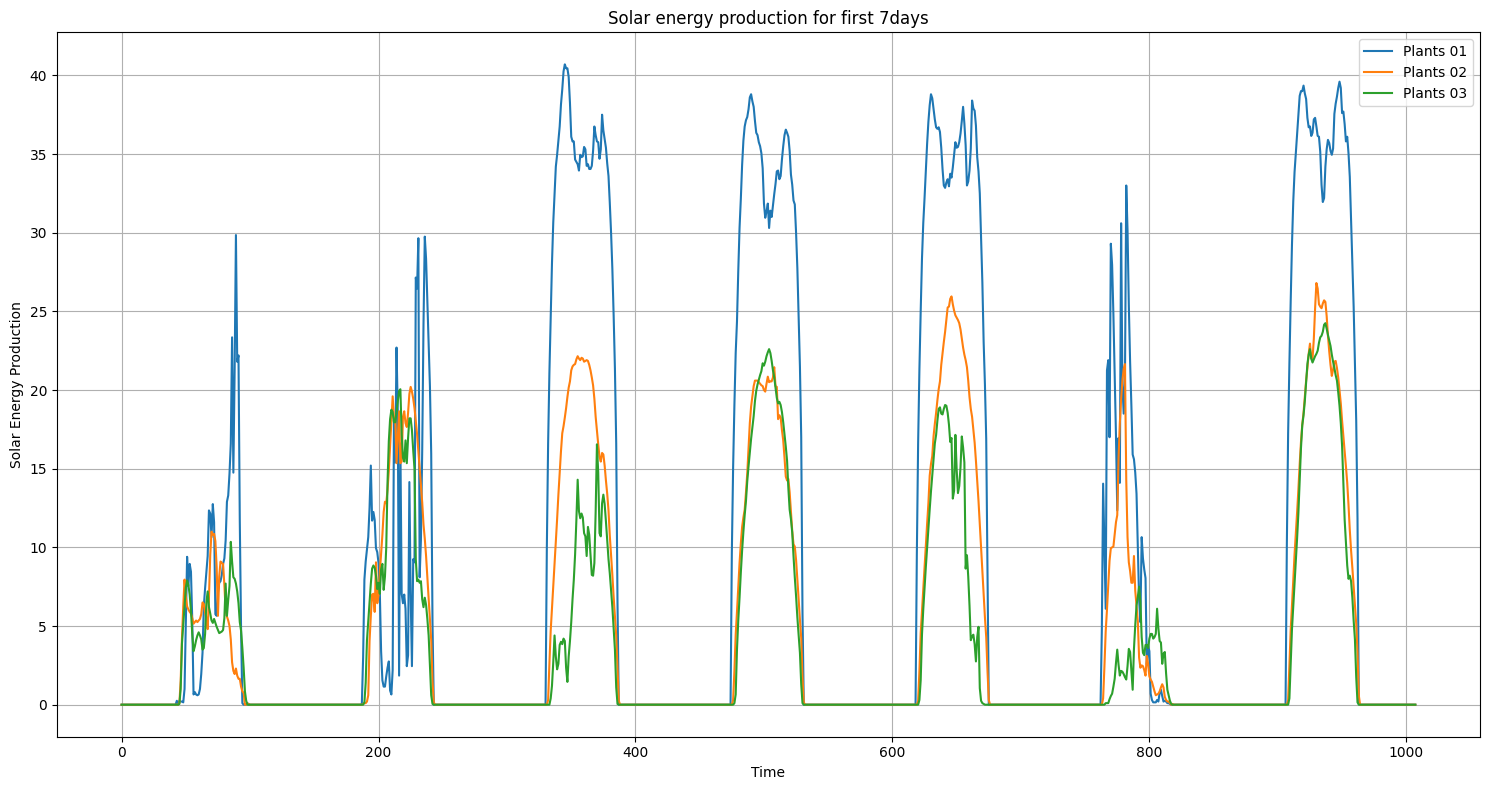

In [ ]:
# Visualizations
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:1008, 0])
plt.plot(df.iloc[:1008, 1])
plt.plot(df.iloc[:1008, 2])
plt.title('Solar energy production for first 7days')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend(['Plants 01', 'Plants 02', 'Plants 03'])
plt.grid(True)
plt.tight_layout()
plt.show()

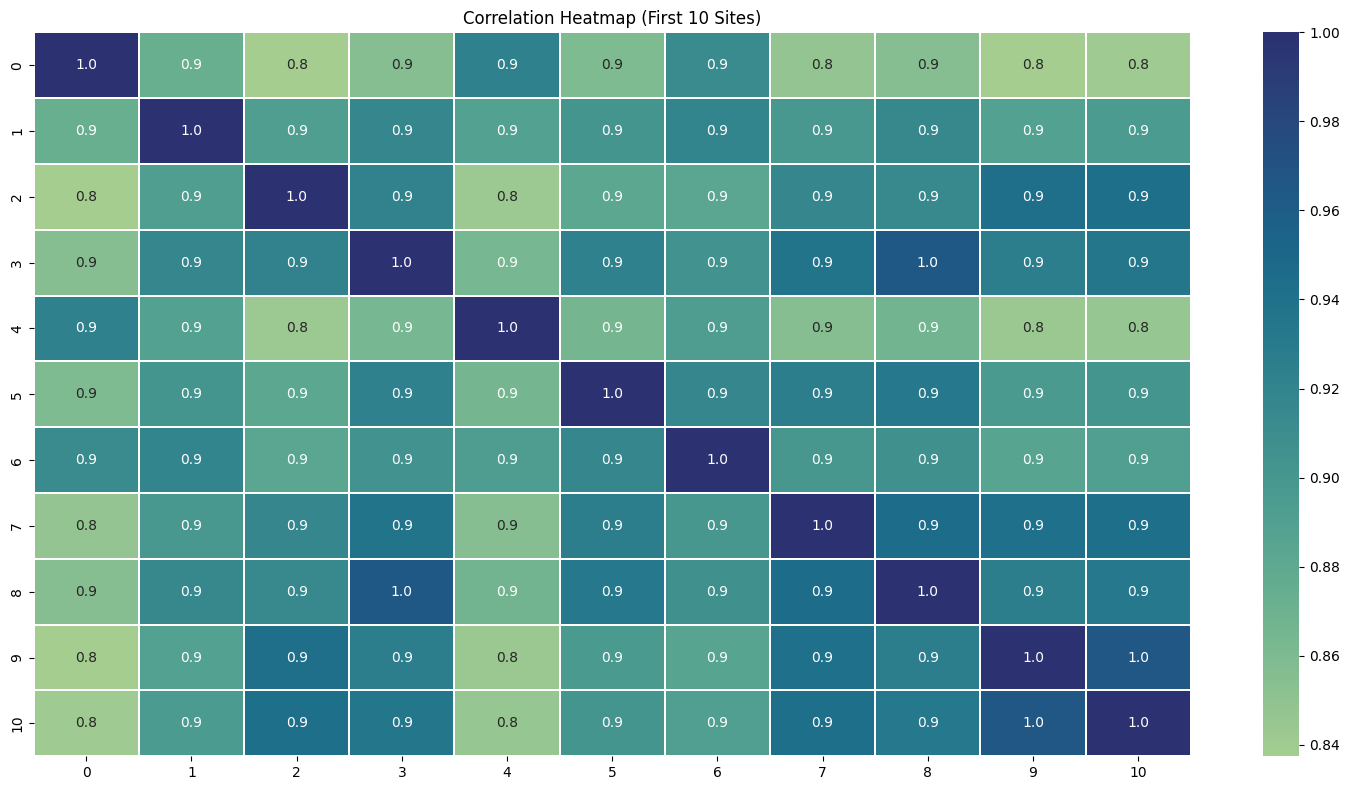

In [ ]:
correlation_subset = df.iloc[:, :11].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='crest', linewidths=0.2, fmt='0.1f')
plt.title('Correlation Heatmap (First 10 Sites)')
plt.tight_layout()
plt.show()


In [ ]:
6*24

144

```
Here's the logic:
In 1 day, there are:

24 hours x 6 entries/hour = 144 entries per day

df.index % 144
→ gives the row number within a day (from 0 to 143)

// 6
→ divides that by 6 to convert from 10-min steps to hour (0 to 23)
```

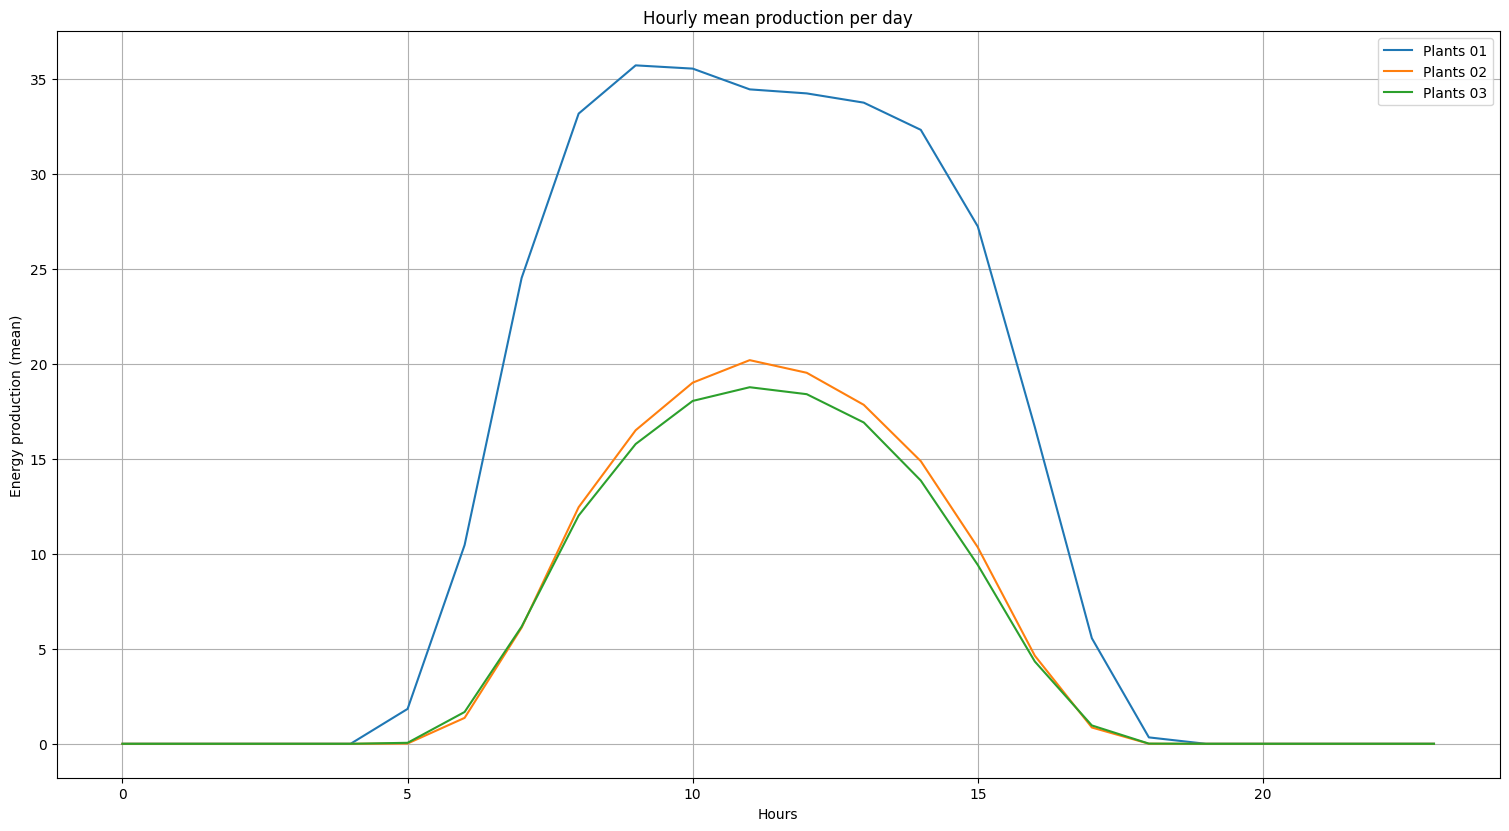

In [ ]:
# Plot average hourly output in a day
df['hours'] = (df.index % 144)//6

plt.figure(figsize=(15,8))
plt.plot(df.groupby(by='hours')[[0,1,2]].mean())
plt.grid(True)
plt.tight_layout()
plt.xlabel('Hours')
plt.ylabel('Energy production (mean)')
plt.title('Hourly mean production per day')
plt.legend(['Plants 01', 'Plants 02', 'Plants 03'])
plt.show()

In [ ]:
# Create datetime index for full 2006 year (10-min intervals)
date_range = pd.date_range(start='2006-01-01', periods=52560, freq='10min')

# df.index = date_range

df['month'] = date_range.month


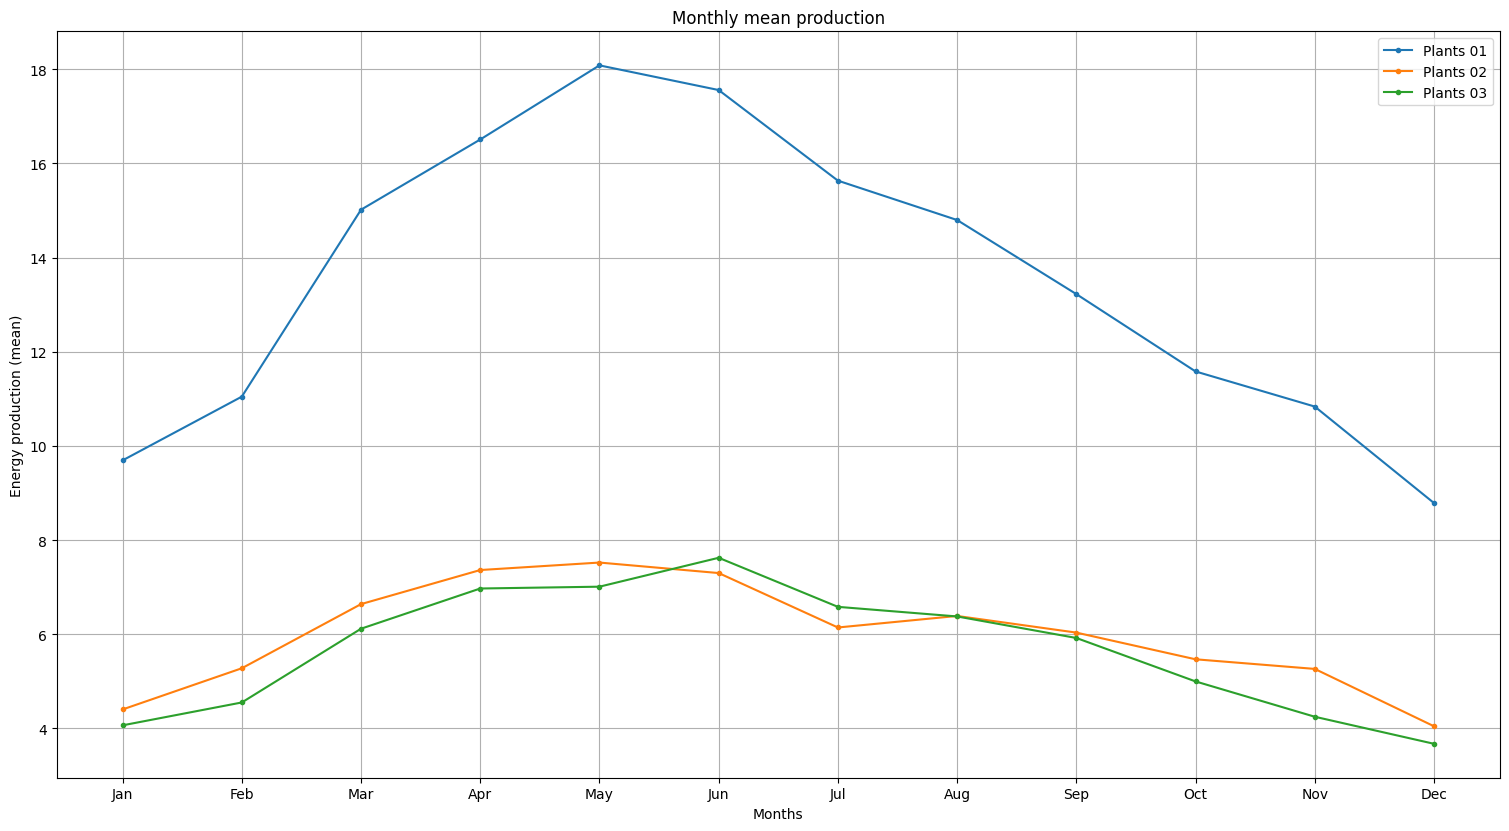

In [ ]:
monthly_avg = df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

# Plot average monthly output (per site)
plt.figure(figsize=(15,8))
plt.plot(range(1, 13), monthly_avg, marker='.')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.xlabel('Months')
plt.ylabel('Energy production (mean)')
plt.title('Monthly mean production')
plt.legend(['Plants 01', 'Plants 02', 'Plants 03'])
plt.show()

In [ ]:
eda_summary['column_stats']

,count,mean,std,min,25%,50%,75%,max
0,52560.0,13.573475,17.611179,0.0,0.0,0.0,30.95,58.85
1,52560.0,5.989026,8.652284,0.0,0.0,0.0,11.45,33.35
2,52560.0,5.683027,8.447994,0.0,0.0,0.0,10.25,33.35
3,52560.0,6.014602,8.841083,0.0,0.0,0.0,11.25,33.15
4,52560.0,11.532876,15.148663,0.0,0.0,0.0,26.35,48.50
...,...,...,...,...,...,...,...,...
132,52560.0,5.659655,8.424734,0.0,0.0,0.0,10.25,31.95
133,52560.0,6.002021,8.669905,0.0,0.0,0.0,11.60,31.85
134,52560.0,5.984339,8.817329,0.0,0.0,0.0,11.10,33.00
135,52560.0,5.746928,7.582154,0.0,0.0,0.0,13.05,24.55


In [ ]:
df.drop(columns=['hours', 'month'], inplace=True)

# Preprocess

In [ ]:
# Time split FIRST
split_ratio = 0.7
split_idx = int(len(df) * split_ratio)

df_train_raw = df.iloc[:split_idx]
df_test_raw  = df.iloc[split_idx:]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fit scaler on TRAIN ONLY
scaler = MinMaxScaler()

df_train = pd.DataFrame(
    scaler.fit_transform(df_train_raw),
    columns=df.columns,
    index=df_train_raw.index
)


# Transform TEST using SAME scaler
df_test = pd.DataFrame(
    scaler.transform(df_test_raw),
    columns=df.columns,
    index=df_test_raw.index
)

In [ ]:
window_size = 168
forecast_horizon = 24  # output sequence length (4 hours)
batch_size = 24
n_nodes = df_train.shape[1]
n_nodes

137

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size)
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size)

# Model: PatchedTalNet

In [ ]:
@tf.keras.utils.register_keras_serializable()
class RevIN(tf.keras.layers.Layer):
    def __init__(self, eps=1e-5, affine=True, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.affine = affine

    def build(self, input_shape):
        n = int(input_shape[-1])
        if self.affine:
            self.gamma = self.add_weight(
                name="gamma", shape=(1, 1, n),
                initializer="ones", trainable=True
            )
            self.beta = self.add_weight(
                name="beta", shape=(1, 1, n),
                initializer="zeros", trainable=True
            )
        super().build(input_shape)

    def call(self, x, mode, stats=None):
        if mode == "norm":
            mu = tf.reduce_mean(x, axis=1, keepdims=True)
            sigma = tf.math.reduce_std(x, axis=1, keepdims=True)
            x_hat = (x - mu) / (sigma + self.eps)
            if self.affine:
                x_hat = x_hat * self.gamma + self.beta
            return x_hat, (mu, sigma)

        elif mode == "denorm":
            mu, sigma = stats
            x_hat = x
            if self.affine:
                x_hat = (x_hat - self.beta) / (self.gamma + self.eps)
            return x_hat * (sigma + self.eps) + mu

    def get_config(self):
        config = super().get_config()
        config.update({
            "eps": self.eps,
            "affine": self.affine
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_len=16, stride=8, d_model=128, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model
        self.dropout_rate = dropout

        self.dropout = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(d_model)
        self.pos_emb = None

    def build(self, input_shape):
        T = int(input_shape[1])
        n_patches = 1 + (T - self.patch_len) // self.stride

        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(1, n_patches, self.d_model),
            initializer="random_normal",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x, training=None):
        patches = tf.signal.frame(
            x, frame_length=self.patch_len,
            frame_step=self.stride,
            axis=1
        )

        B = tf.shape(patches)[0]
        n_patches = tf.shape(patches)[1]
        N = tf.shape(patches)[3]

        patches = tf.reshape(patches, [B, n_patches, self.patch_len * N])
        tokens = self.proj(patches)
        tokens = tokens + self.pos_emb
        tokens = self.dropout(tokens, training=training)
        return tokens

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_len": self.patch_len,
            "stride": self.stride,
            "d_model": self.d_model,
            "dropout": self.dropout_rate
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchedTalNet(tf.keras.Model):
    def __init__(self, n_nodes, horizon,
                 patch_len=16, patch_stride=8,
                 d_model=128, n_heads=8, n_stack=2,
                 dropout_rate=0.2,
                 pool_lstm_units=None,
                 **kwargs):
        super().__init__(**kwargs)

        self.n_nodes = n_nodes
        self.horizon = horizon
        self.patch_len = patch_len
        self.patch_stride = patch_stride
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.pool_lstm_units = pool_lstm_units

        self.revin = RevIN()

        self.patch = PatchEmbedding(
            patch_len=patch_len,
            stride=patch_stride,
            d_model=d_model,
            dropout=dropout_rate,
            name="patch_embedding"
        )

        key_dim = max(8, d_model // n_heads)

        self.blocks = []
        for _ in range(n_stack):
            self.blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(
                    num_heads=n_heads,
                    key_dim=key_dim,
                    dropout=dropout_rate
                ),
                "drop1": tf.keras.layers.Dropout(dropout_rate),
                "add1": tf.keras.layers.Add(),
                "norm1": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(4 * d_model, activation="relu"),
                    tf.keras.layers.Dropout(dropout_rate),
                    tf.keras.layers.Dense(d_model),
                ]),
                "drop2": tf.keras.layers.Dropout(dropout_rate),
                "add2": tf.keras.layers.Add(),
                "norm2": tf.keras.layers.LayerNormalization(),
            })

        units = pool_lstm_units if pool_lstm_units else (d_model // 2)

        self.pool = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                units,
                return_sequences=False,
                dropout=dropout_rate * 0.7
            )
        )

        self.out_drop = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x, training=None):

        x, stats = self.revin(x, mode="norm")
        h = self.patch(x, training=training)

        for b in self.blocks:
            attn = b["attn"](h, h, training=training)
            attn = b["drop1"](attn, training=training)
            h = b["add1"]([h, attn])
            h = b["norm1"](h)

            ffn = b["ffn"](h, training=training)
            ffn = b["drop2"](ffn, training=training)
            h = b["add2"]([h, ffn])
            h = b["norm2"](h)

        # Moved outside loop (important!)
        z = self.pool(h, training=training)
        z = self.out_drop(z, training=training)

        y = self.fc(z)
        y = tf.reshape(y, [-1, self.horizon, self.n_nodes])
        y = self.revin(y, mode="denorm", stats=stats)

        return y

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "horizon": self.horizon,
            "patch_len": self.patch_len,
            "patch_stride": self.patch_stride,
            "d_model": self.d_model,
            "n_heads": self.n_heads,
            "n_stack": self.n_stack,
            "dropout_rate": self.dropout_rate,
            "pool_lstm_units": self.pool_lstm_units,
        })
        return config

In [ ]:
model = PatchedTalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    patch_len=16,
    patch_stride=4,
    d_model=128,
    n_heads=8,
    n_stack=1,
    dropout_rate=0.25
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    clipnorm=1.0),
    loss= tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - loss: 0.0298 - mae: 0.1919 - val_loss: 0.0135 - val_mae: 0.1059
Epoch 2/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - loss: 0.0149 - mae: 0.1144 - val_loss: 0.0097 - val_mae: 0.0913
Epoch 3/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - loss: 0.0114 - mae: 0.0979 - val_loss: 0.0084 - val_mae: 0.0836
Epoch 4/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - loss: 0.0101 - mae: 0.0913 - val_loss: 0.0077 - val_mae: 0.0778
Epoch 5/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - loss: 0.0095 - mae: 0.0873 - val_loss: 0.0073 - val_mae: 0.0747
Epoch 6/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step - loss: 0.0092 - mae: 0.0850 - val_loss: 0.0071 - val_mae: 0.0725
Epoch 7/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step - loss: 0.0089 - mae: 0.0830 - val_loss: 0.0068 - val_mae: 0.0709
Epoch 8/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - loss: 0.0086 - mae: 0.0816 - val_loss: 0.0066 - val_mae: 0.0699
Epoch 9/100
1525

# Evaluation

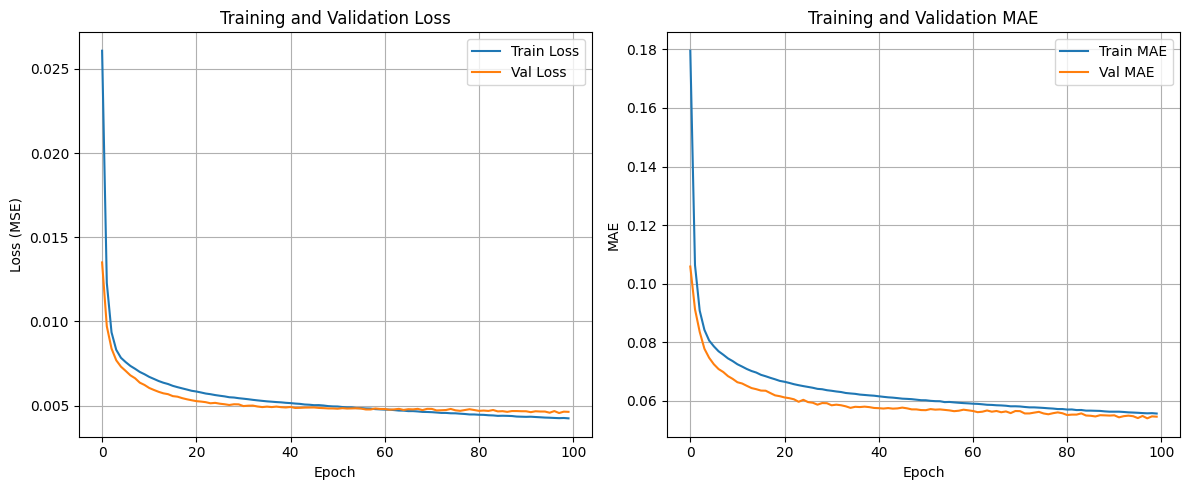

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }


In [ ]:
# Collect y_test from the test_dataset
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)

649/649 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
print(f'Model Name: Patched TalNet')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: Patched TalNet
Step  3 --> R²=0.9217, RMSE=0.0697, MAE=0.0396, MSE=0.0049, SMAPE=134.93%, RSE=0.2799, CORR=0.9638
Step  6 --> R²=0.9144, RMSE=0.0729, MAE=0.0415, MSE=0.0053, SMAPE=135.47%, RSE=0.2926, CORR=0.9601
Step 12 --> R²=0.8957, RMSE=0.0805, MAE=0.0458, MSE=0.0065, SMAPE=136.61%, RSE=0.3230, CORR=0.9510
Step 24 --> R²=0.8531, RMSE=0.0955, MAE=0.0541, MSE=0.0091, SMAPE=138.64%, RSE=0.3833, CORR=0.9277


## Plots After train

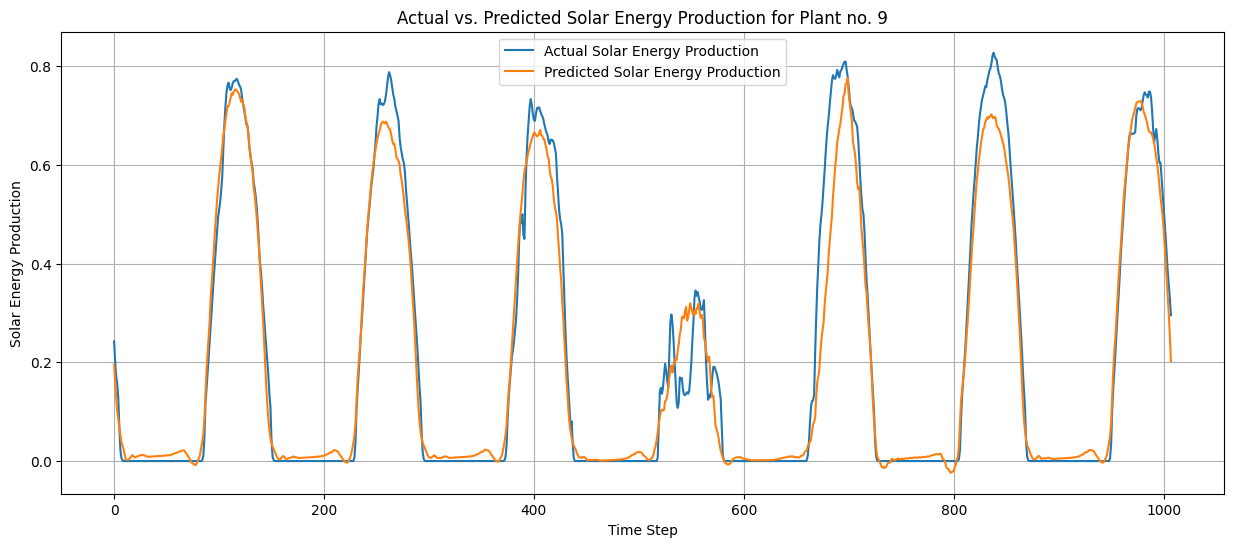

In [ ]:
# Actual Vs Predicted Solar Energy Production Curve

sample_node = 9
sample_time_steps = 1008

plt.figure(figsize=(15, 6))
plt.plot(y_test[:sample_time_steps, 0, sample_node], label='Actual Solar Energy Production')
plt.plot(y_pred[:sample_time_steps, 0, sample_node], label='Predicted Solar Energy Production')
plt.title(f'Actual vs. Predicted Solar Energy Production for Plant no. {sample_node}')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast_horizon

24

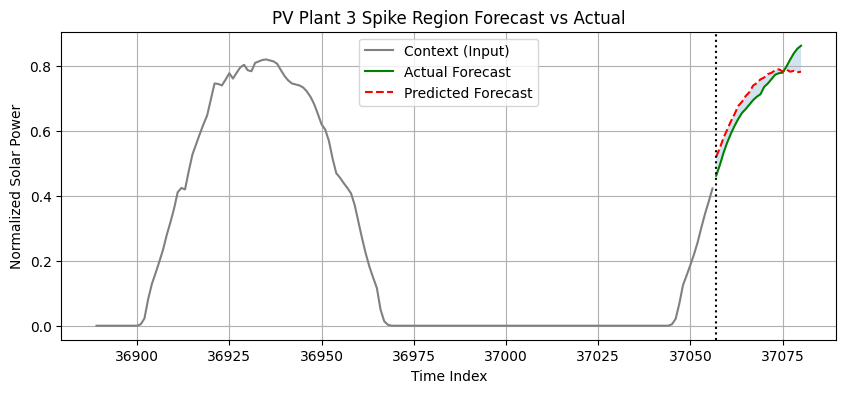

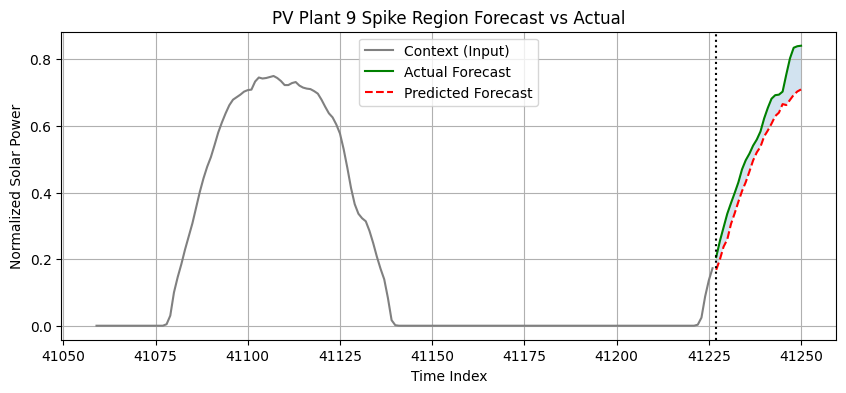

In [ ]:
# Walk-forward Plot (PV Plants)

plants_to_plot = [3, 9]

for p in plants_to_plot:
    peak_idx = np.argmax(np.max(y_test[:, :, p], axis=1))

    context_start = peak_idx
    context_end = peak_idx + window_size
    forecast_start = context_end
    forecast_end = context_end + forecast_horizon

    plt.figure(figsize=(10,4))

    plt.plot(df_test.index[context_start:context_end],
             df_test.iloc[context_start:context_end, p],
             label='Context (Input)', color='gray')

    time_range = df_test.index[forecast_start:forecast_end]
    actual_vals = y_test[peak_idx, :, p].flatten()
    pred_vals = y_pred[peak_idx, :, p].flatten()

    plt.plot(time_range, actual_vals, label='Actual Forecast', color='green')
    plt.plot(time_range, pred_vals, label='Predicted Forecast', color='red', linestyle='--')

    plt.axvline(x=df_test.index[forecast_start], color='black', linestyle=':')
    plt.fill_between(time_range, actual_vals, pred_vals, alpha=0.2)

    plt.title(f'PV Plant {p} Spike Region Forecast vs Actual')
    plt.xlabel('Time Index')
    plt.ylabel('Normalized Solar Power')
    plt.legend()
    plt.grid(True)
    plt.show()

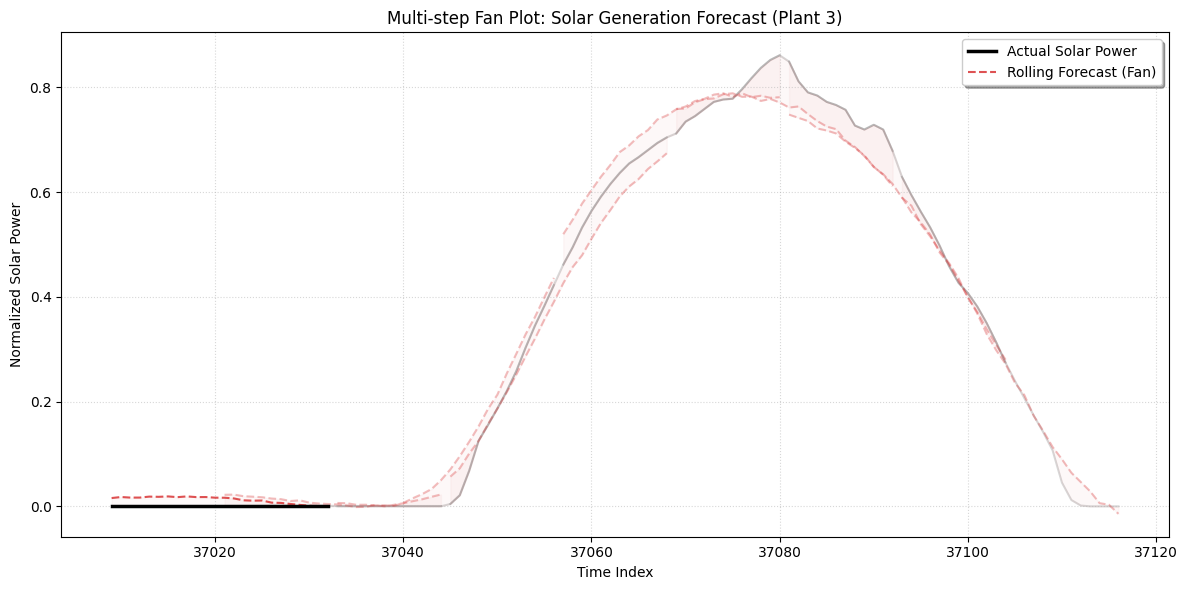

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plant_idx = 3
n_forecasts = 8
step_size = forecast_horizon // 2

plt.figure(figsize=(12, 6))

start_offset = np.argmax(np.max(y_test[:, :, plant_idx], axis=1)) - (n_forecasts * step_size // 2)

for i in range(n_forecasts):
    win_idx = start_offset + (i * step_size)

    forecast_idx = df_test.index[win_idx + window_size : win_idx + window_size + forecast_horizon]
    actual_vals = y_test[win_idx, :, plant_idx].flatten()
    pred_vals = y_pred[win_idx, :, plant_idx].flatten()

    if i == 0:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=2.5, label='Actual Solar Power', zorder=10)
        plt.plot(forecast_idx, pred_vals, color='tab:red', alpha=0.8, linestyle='--', label='Rolling Forecast (Fan)', zorder=5)
    else:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=1.5, alpha=0.15, zorder=1)
        plt.plot(forecast_idx, pred_vals, color='tab:red', alpha=0.3, linestyle='--', zorder=5)

    plt.fill_between(forecast_idx, actual_vals, pred_vals, color='tab:red', alpha=0.03)

plt.title(f'Multi-step Fan Plot: Solar Generation Forecast (Plant {plant_idx})')
plt.xlabel('Time Index')
plt.ylabel('Normalized Solar Power')
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

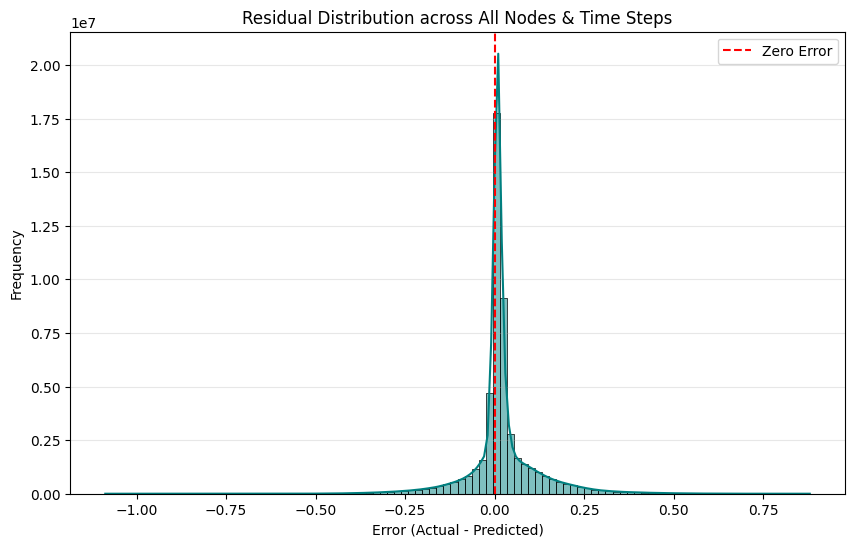

Mean Residual: 0.0206
Residual Std Dev: 0.0933


In [ ]:
# Residual Distribution

residuals = (y_test - y_pred).flatten()
plt.figure(figsize=(10, 6))

# Plotting the distribution with a Kernel Density Estimate (KDE)
sns.histplot(residuals, kde=True, color='teal', bins=100)

# Add a vertical line at 0 to show the perfect prediction center
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')

plt.title('Residual Distribution across All Nodes & Time Steps')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print basic residual statistics
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Std Dev: {np.std(residuals):.4f}")

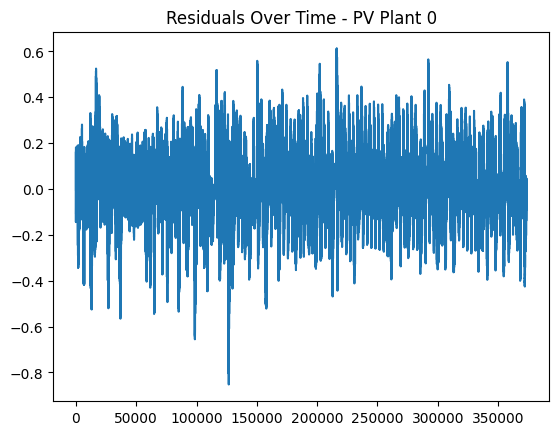

In [ ]:
# Residual Over time (Time Series Plot)

residuals = y_test - y_pred
plt.plot(residuals[:, :, 0].flatten())
plt.title('Residuals Over Time - PV Plant 0')
plt.show()

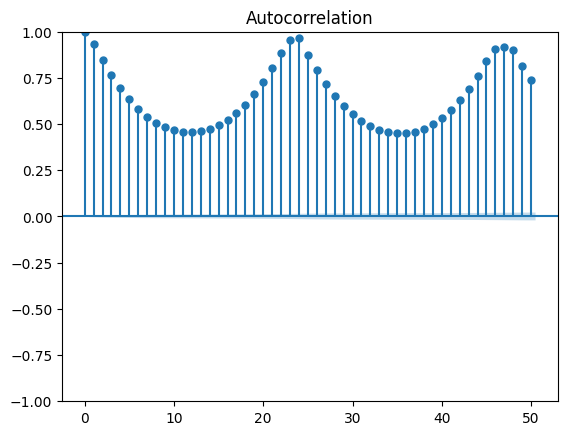

In [ ]:
# Residual Autocorrelation

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals[:, :, 3].flatten(), lags=50)
plt.show()

# Model Saving

In [ ]:
model.save('/content/drive/MyDrive/data/varsity/PatchedTalNet_solar.keras')

In [ ]:
save_dir = "/content/drive/MyDrive/data/varsity/PatchedTalNet_solar.keras"
model = tf.keras.models.load_model(save_dir, compile=False)
print("Model loaded successfully")

Model loaded successfully


# Model Loading with fix

In [ ]:
import zipfile

In [ ]:
keras_path = "/content/drive/MyDrive/data/varsity/TalNetV2_solar.keras"
extract_dir = "/content/extracted_model"

with zipfile.ZipFile(keras_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")
print("Contents:", os.listdir(extract_dir))

Extraction complete.
Contents: ['metadata.json', 'config.json', 'model.weights.h5']


In [ ]:
n_nodes

137

In [ ]:
model = PatchedTalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    patch_len=16,
    patch_stride=4,
    d_model=128,
    n_heads=8,
    n_stack=1,
    dropout_rate=0.25
)

dummy = tf.random.normal((1, 168, 137))
_ = model(dummy)

print("Model built.")

Model built.


In [ ]:
weights_path = os.path.join(extract_dir, "model.weights.h5")

model.load_weights(weights_path)

print("Weights restored successfully.")

Weights restored successfully.


In [ ]:
save_dir = "/content/drive/MyDrive/data/varsity/PatchedTalNet_solar.keras"
model.save(save_dir)  # saves in SavedModel format
print(f"Model saved successfully at {save_dir}")

Model saved successfully at /content/drive/MyDrive/data/varsity/PatchedTalNet_solar.keras


In [ ]:
loaded_model = tf.keras.models.load_model(save_dir, compile=False)
print("Model loaded successfully")

Model loaded successfully
